# 1.6c: Full Universe from Cluster Perspective

This notebook visualizes ALL 151,936 tokens from the cluster's perspective to test whether the apparent spiral structure is real or an artifact of the overdensity bounding box.

## The Question

In 1.6b, we saw a striking asymmetry when viewing the 18,161 non-cluster overdensity tokens from the cluster's perspective:
- Dense concentration around -135° to -180° longitude
- Apparent spiral/gradient structure rotating clockwise
- Much sparser coverage in other directions

**Is this real structure, or a boundary artifact?**

The 20,373 overdensity tokens were originally selected using a **rectilinear bounding box** in spherical coordinates (lat: [-15°, 5°], lon: [-10°, 20°], r: [0.2, 0.5] from global origin). When viewed from the cluster centroid (offset from global origin), this box's boundaries could create artificial patterns.

**Test:** Plot the **full 151,936-token vocabulary** from cluster perspective.
- If spiral disappears → boundary artifact
- If spiral persists → real geometric structure in token space

## Method

We'll:
1. Load cluster-centric reference frame
2. Compute spherical coordinates for ALL tokens from cluster centroid
3. Plot with same size scaling (proximity to cluster)
4. Compare to 1.6b to see if the spiral is real or artifact

## Parameters

In [11]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis selection (for spherical coordinates)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Point size scaling
BASE_SIZE = 500  # Maximum size (for closest tokens)
ALPHA = 0.5     # Transparency (lower for dense full-sky view)
EPSILON = 0.01  # Offset for inverse square to prevent division by zero

# Color
POINT_COLOR = 'steelblue'

# Visualization
FIGSIZE = (16, 8)
DPI = 200

## Imports

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [13]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [14]:
# Load W (full vocabulary)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions


In [15]:
# Load cluster-centric reference frame
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid: {cluster_centroid.shape}")
print(f"  Centroid norm: {torch.linalg.vector_norm(cluster_centroid).item():.6f}")
print(f"  PCA eigenvectors: {eigenvectors.shape}")


Loaded reference frame:
  Cluster centroid: torch.Size([2560])
  Centroid norm: 0.370917
  PCA eigenvectors: torch.Size([2560, 2560])


## Define Spherical Basis

In [16]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"\nSpherical basis defined:")
print(f"  North: PC{NORTH_PC}")
print(f"  Meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")


Spherical basis defined:
  North: PC2
  Meridian: PC1
  Equinox: PC3


## Compute Spherical Coordinates from Cluster Centroid

In [17]:
print("\nComputing spherical coordinates for ALL tokens from cluster centroid...\n")

# Translate to cluster-centric frame
W_centered = W - cluster_centroid

# Project onto basis
x = W_centered @ meridian
y = W_centered @ equinox
z = W_centered @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Spherical coordinates computed for all {N:,} tokens")
print(f"\nRadial distance statistics:")
print(f"  Min: {r.min().item():.6f}")
print(f"  Max: {r.max().item():.6f}")
print(f"  Mean: {r.mean().item():.6f}")
print(f"  Median: {r.median().item():.6f}")


Computing spherical coordinates for ALL tokens from cluster centroid...

✓ Spherical coordinates computed for all 151,936 tokens

Radial distance statistics:
  Min: 0.000000
  Max: 1.122656
  Mean: 0.162215
  Median: 0.159331


## Compute Point Sizes

In [18]:
print("\nComputing point sizes...\n")

# Convert to numpy
r_np = r.cpu().numpy()
lat_np = lat_deg.cpu().numpy()
lon_np = lon_deg.cpu().numpy()

# Inverse square scaling: close = MUCH bigger, far = much smaller
r_max = r_np.max()
r_min = r_np.min()

# Normalize distances to [0, 1] range
r_normalized = (r_np - r_min) / (r_max - r_min)

# Inverse square with offset to prevent division by zero
sizes = BASE_SIZE * (1 / (r_normalized + EPSILON))**2

# Rescale to reasonable range
sizes = sizes / sizes.max() * BASE_SIZE

print(f"✓ Point sizes computed")
print(f"  Size range: [{sizes.min():.2f}, {sizes.max():.2f}]")
print(f"  Mean size: {sizes.mean():.2f}")


Computing point sizes...

✓ Point sizes computed
  Size range: [0.05, 500.00]
  Mean size: 11.79


## Mollweide Sky Map


Creating Mollweide sky map...



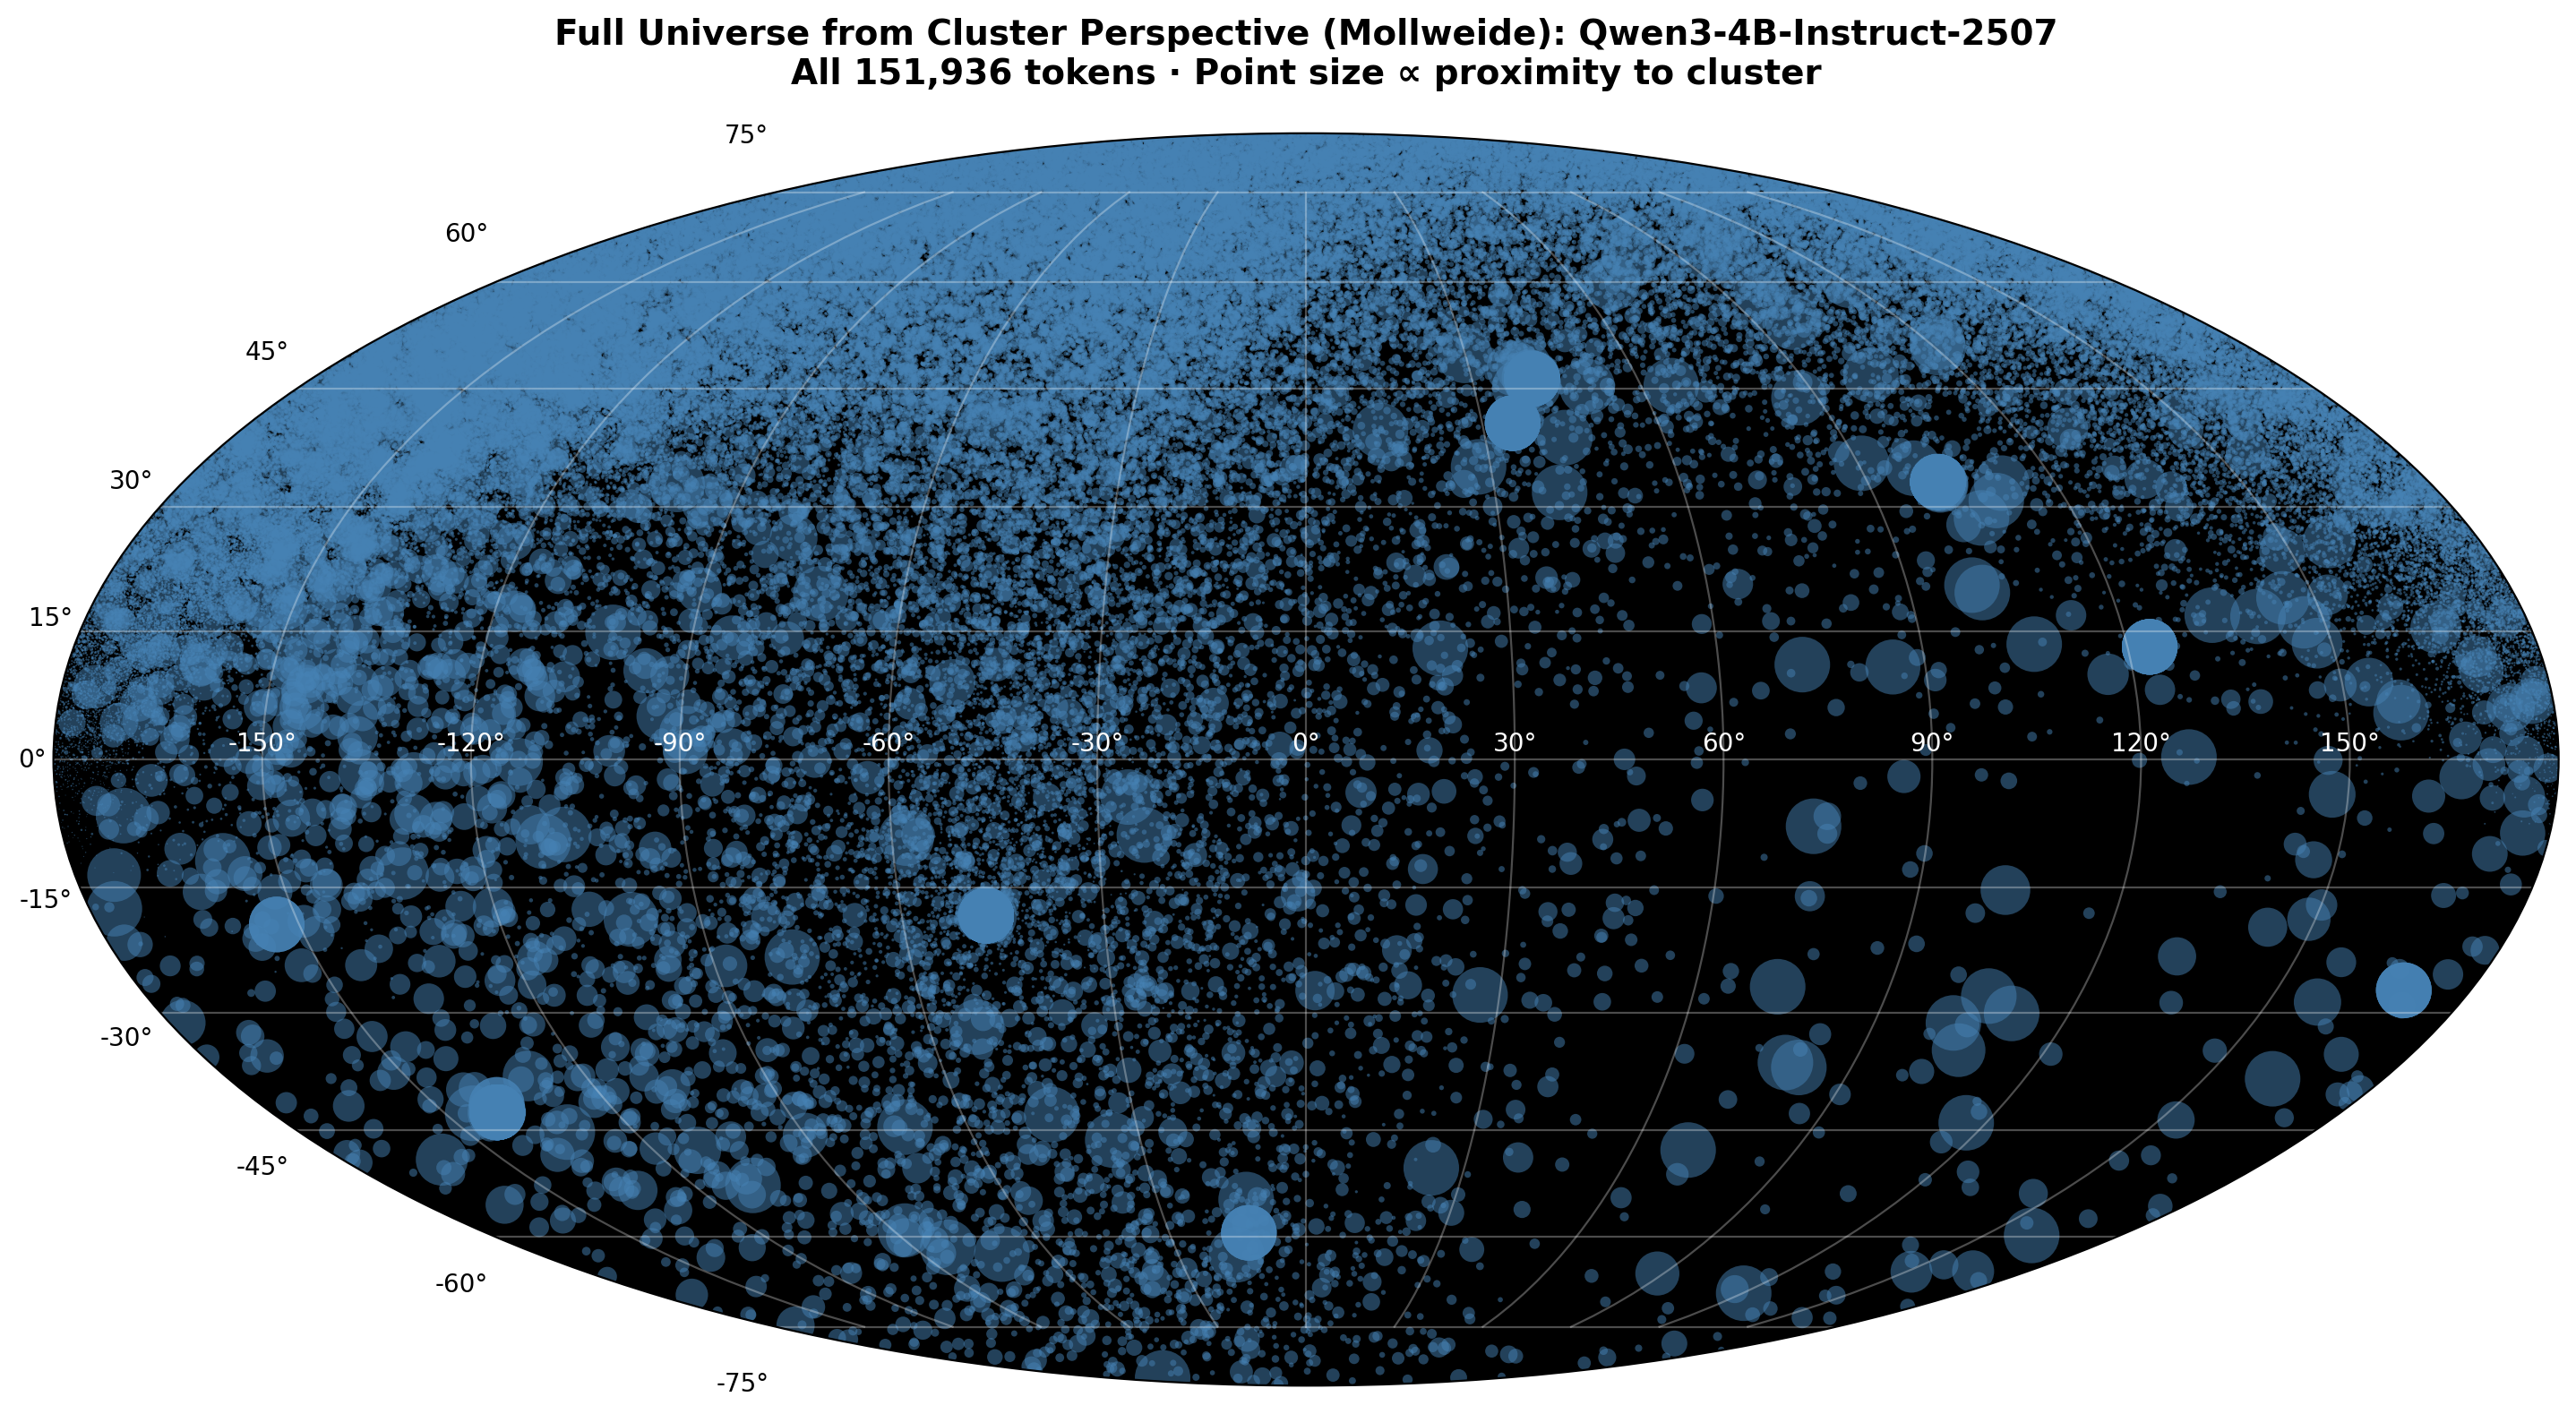

✓ Mollweide sky map complete


In [19]:
print(f"\nCreating Mollweide sky map...\n")

# Convert to radians for plotting
lon_rad = np.deg2rad(lon_np)
lat_rad = np.deg2rad(lat_np)

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Scatter plot
ax.scatter(lon_rad, lat_rad, 
           s=sizes, 
           alpha=ALPHA, 
           c=POINT_COLOR,
           edgecolors='none',
           rasterized=True)

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Full Universe from Cluster Perspective (Mollweide): {MODEL_NAME}\n' + 
             f'All {N:,} tokens · Point size ∝ proximity to cluster',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide sky map complete")

## Polar (Equatorial) Sky Map


Creating polar sky map...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_17116/1120116200.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


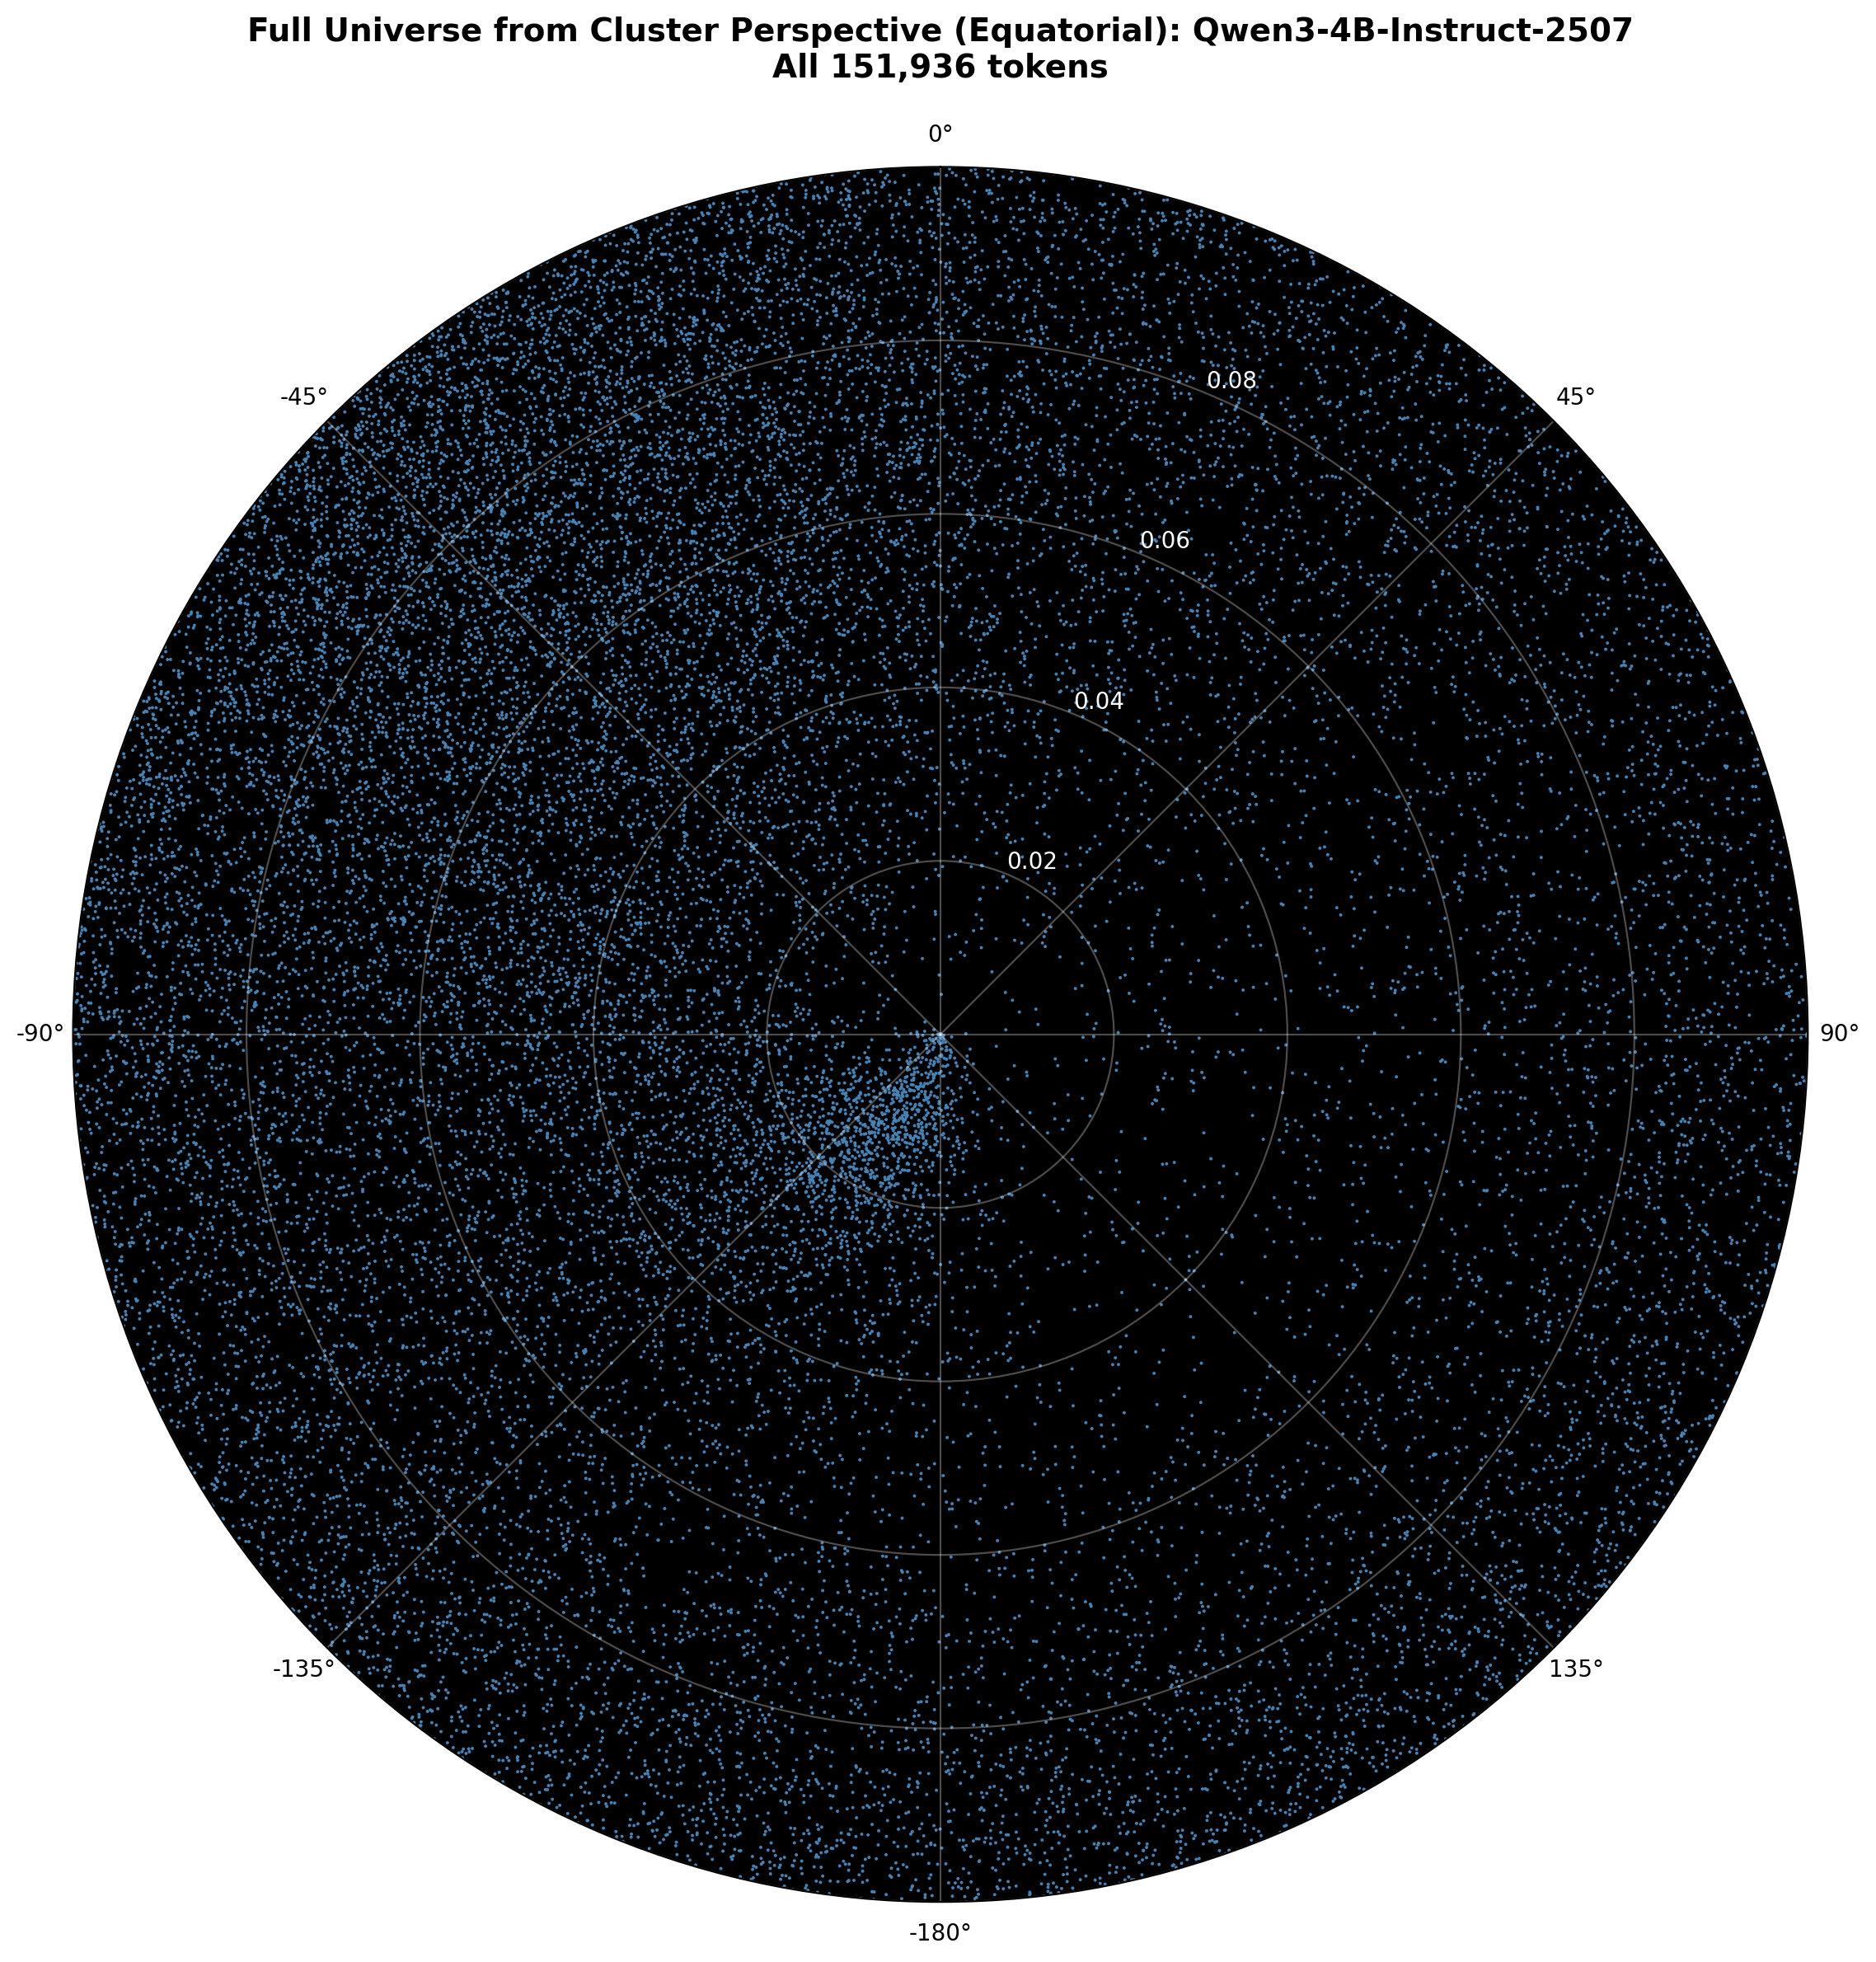

✓ Polar sky map complete


In [24]:
print(f"\nCreating polar sky map...\n")

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Scatter plot
ax.scatter(lon_rad, r_np, 
           s=2.0, 
           alpha=1.0, 
           c=POINT_COLOR,
           edgecolors='none',
           rasterized=True)

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Full Universe from Cluster Perspective (Equatorial): {MODEL_NAME}\n' + 
             f'All {N:,} tokens',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

ax.set_rlim(bottom=0, top=0.1)

plt.tight_layout()
plt.show()

print("✓ Polar sky map complete")

## Observations

Compare to 1.6b (overdensity tokens only):

**If spiral disappears:**
- Full universe shows uniform coverage in all directions
- Spiral in 1.6b was artifact of rectilinear bounding box
- Overdensity is just "ice cube in uniform gas" after all
- No real geometric structure, just sampling boundary effects

**If spiral persists:**
- Same asymmetry visible even with all tokens
- Real geometric structure in token space
- Tokens are NOT uniformly distributed around cluster
- Suggests:
  - Anisotropic accretion?
  - Filamentary structure?
  - Multiple sub-clusters?
  - Cluster formed at edge of larger overdensity?

**Key diagnostic:**
Look at the -135° to -180° wedge. In 1.6b, this region was extremely dense with large (nearby) tokens. Does the full universe show:
- Even coverage everywhere (spiral was artifact)
- Same asymmetry (spiral is real structure)